# Explanatory Data Analysis
Understanding the dataset extracted by the JAMA paper.

# settings

In [1]:
import re
import pandas as pd


In [2]:
# Load the data
df=pd.read_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_raw.csv")
df.head()


,link,question,opa,opb,opc,opd,diagnosis,answer_idx,answer,explanation,field
0,https://jamanetwork.com/journals/jamadermatolo...,A man in his 30s with AIDS presented with acut...,Herpes simplex virus,Histoplasmosis,Molluscum contagiosum,Mpox,D. Mpox,D,Mpox,The photographs demonstrate a Tzanck smear usi...,JAMA Dermatology Clinicopathological Challenge
1,https://jamanetwork.com/journals/jama/fullarti...,An 80-year-old man with stage II bladder carci...,Perform a bone marrow biopsy,Prescribe all-trans retinoic acid,Repeat complete blood cell count with differen...,Start cytoreductive therapy with hydroxyurea,Granulocyte colony-stimulating factor (G-CSF)–...,C,Repeat complete blood cell count with differen...,The key to the correct diagnosis is recognizin...,JAMA Clinical Challenge
2,https://jamanetwork.com/journals/jamaneurology...,A 68-year-old man presented with progressive r...,Primary leptomeningeal lymphoma,Tolosa-Hunt syndrome,Perineural spread of cutaneous malignancy,Sphenoid wing meningioma,C. Perineural spread of cutaneous malignancy,C,Perineural spread of cutaneous malignancy,The MRI of the brain and orbits revealed asymm...,JAMA Neurology Clinical Challenge
3,https://jamanetwork.com/journals/jamaoncology/...,A 31-year-old man presented with left cervical...,Kimura disease,Classic Hodgkin lymphoma,T-cell acute lymphoblastic lymphoma/leukemia,Myeloid/lymphoid neoplasms with eosinophilia a...,D. Myeloid/lymphoid neoplasms with eosinophili...,D,Myeloid/lymphoid neoplasms with eosinophilia a...,The differential diagnoses in young men with e...,JAMA Oncology Clinical Challenge
4,https://jamanetwork.com/journals/jamaotolaryng...,A 28-year-old woman presented with a 5-day his...,Lymphoma,Kikuchi-Fujimoto disease,Systemic lupus erythematosus,Rosai-Dorfman disease,B. Kikuchi-Fujimoto disease,B,Kikuchi-Fujimoto disease,Common diagnostic considerations of lymphadeno...,Clinical Challenge


df.columns

In [3]:
for i in range(5):
    print (df.iloc[i]['question'])
    print("--")


A man in his 30s with AIDS presented with acute-onset painful scattered umbilicated papulopustules and ovoid ulcerated plaques with elevated, pink borders on the face, trunk, and extremities (Figure, A). The patient also had a new-onset cough but was afebrile and denied other systemic symptoms. Due to his significant immunocompromise, the clinical presentation was highly suspicious for infection. For rapid bedside differentiation of multiple infectious etiologies, a Tzanck smear was performed by scraping the base of an ulcerated lesion and inner aspect of a pseudopustule and scraping its base with a #15 blade. These contents were placed on a glass slide, fixed, and stained with Wright-Giemsa and subsequently Papanicolaou staining to further characterize the changes seen.A, Clinical image demonstrating papulopustules and ovoid ulcerated plaques with elevated, pink borders on the elbows. B, Tzanck smear using Wright-Giemsa staining of specimen demonstrating ballooning of keratinocytes an

# 0. Numerical data

In [4]:
df.describe()


,link,question,opa,opb,opc,opd,diagnosis,answer_idx,answer,explanation,field
count,1522,1522,1522,1522,1522,1522,1443,1522,1522,1522,1522
unique,1522,1522,1346,1388,1389,1356,1403,4,1423,1522,13
top,https://jamanetwork.com/journals/jamadermatolo...,A man in his 30s with AIDS presented with acut...,Squamous cell carcinoma,Pyoderma gangrenosum,Lymphoma,Sarcoidosis,C. Amyloidosis,C,Genetic testing,The photographs demonstrate a Tzanck smear usi...,JAMA Ophthalmology Clinical Challenge
freq,1,1,15,5,8,12,4,582,6,1,378


Options A,B,C,D has common answers, meaning that common diagnosis -> common clinical cases => to explore further

# Data extraction and analysis

### 1. Case and Questions

In [5]:
import pandas as pd
import re

def split_case_question(text):
    question_words = ['What', 'Why', 'When', 'Where', 'Who', 'Which', 'Whose', 'Whom', 'Are', 'Should', 'Will', 'Does', 'Did','How', 'Decide']
    
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Find the last occurrence of any question word
    last_word = None
    last_index = -1
    for word in question_words:
        index = text_lower.rfind(word.lower())
        if index > last_index:
            last_index = index
            last_word = word
    
    if last_index != -1:
        # Use the index from the lowercase search on the original text
        return text[:last_index].strip(), text[last_index:].strip()
    else:
        return text, ''

# Apply the function to your DataFrame
df[['case', 'clinical_question']] = df['question'].apply(split_case_question).tolist()

# Test the result
print("Case:", df['case'][0])
print("\nClinical Question:", df['clinical_question'][0])


Case: A man in his 30s with AIDS presented with acute-onset painful scattered umbilicated papulopustules and ovoid ulcerated plaques with elevated, pink borders on the face, trunk, and extremities (Figure, A). The patient also had a new-onset cough but was afebrile and denied other systemic symptoms. Due to his significant immunocompromise, the clinical presentation was highly suspicious for infection. For rapid bedside differentiation of multiple infectious etiologies, a Tzanck smear was performed by scraping the base of an ulcerated lesion and inner aspect of a pseudopustule and scraping its base with a #15 blade. These contents were placed on a glass slide, fixed, and stained with Wright-Giemsa and subsequently Papanicolaou staining to further characterize the changes seen.A, Clinical image demonstrating papulopustules and ovoid ulcerated plaques with elevated, pink borders on the elbows. B, Tzanck smear using Wright-Giemsa staining of specimen demonstrating ballooning of keratinocy

In [6]:
df['clinical_question'] = df['clinical_question'].str.lower()
# df['clinical_question'].unique()
df['clinical_question'].value_counts()


clinical_question
what is your diagnosis?                                                      752
what would you do next?                                                      644
what is the diagnosis?                                                        62
how do you interpret these test results?                                      35
how do you interpret these results?                                           12
how would you interpret these test results?                                    4
how would you interpret these results?                                         3
what is your diagnosis                                                         2
what would you do next                                                         2
which lesion could explain this patient’s symptoms?                            1
what to do next                                                                1
how do you interpret the test results from day 3 postoperatively at 3 am?      1
how would 

In [7]:
def normalize_question(question):
    # Convert to lowercase and remove punctuation
    question = re.sub(r'[^\w\s]', '', question.lower())
    
    # Map similar phrases to a standard form
    if 'what is your diagnosis' in question:
        return 'what is your diagnosis?'
    elif 'what is the diagnosis' in question:
        return 'what is your diagnosis?'
    elif 'what would you do next' in question:
        return 'what would you do next?'
    elif 'how do you interpret' in question or 'how would you interpret' in question:
        if 'test results' in question or 'tests results' in question:
            return 'how do you interpret these results?'
        else:
            return 'how do you interpret these results?'
    elif 'which lesion' in question:
        return 'which lesion could explain this patients symptoms?'
    elif 'what to do next' in question:
        return 'what would you do next?'
    elif 'most likely diagnosis' in question:
        return 'what is your diagnosis?'
    else:
        return question  # If no match, return the normalized question as is

# Apply the normalization function to create a new column
df['normalized_question'] = df['clinical_question'].apply(normalize_question)

# Get the value counts of the normalized questions
normalized_counts = df['normalized_question'].value_counts()

# Display the results
print(normalized_counts)

# Optionally, create a mapping to show which original questions were mapped to each normalized form
question_mapping = df.groupby('normalized_question')['clinical_question'].unique()
for norm_q, orig_qs in question_mapping.items():
    print(f"\nNormalized: {norm_q}")
    for q in orig_qs:
        print(f"  Original: {q}")


normalized_question
what is your diagnosis?                               817
what would you do next?                               647
how do you interpret these results?                    57
which lesion could explain this patients symptoms?      1
Name: count, dtype: int64

Normalized: how do you interpret these results?
  Original: how do you interpret these test results?
  Original: how do you interpret these results?
  Original: how do you interpret the test results from day 3 postoperatively at 3 am?
  Original: how would you interpret these test results?
  Original: how would you interpret these results?
  Original: how would you interpret this patient’s test results?
  Original: how do you interpret these tests results?

Normalized: what is your diagnosis?
  Original: what is your diagnosis?
  Original: what is your diagnosis
  Original: what is the diagnosis?
  Original: what is the most likely diagnosis?

Normalized: what would you do next?
  Original: what would you do nex

In [8]:

df['normalized_question'].value_counts()


normalized_question
what is your diagnosis?                               817
what would you do next?                               647
how do you interpret these results?                    57
which lesion could explain this patients symptoms?      1
Name: count, dtype: int64

### 2. Test results

#### a. Images

In [9]:

def has_imaging_test(text):
    # List of common imaging tests and related terms
    imaging_terms = [
        'CT', 'CAT scan', 'computed tomography',
        'MRI', 'magnetic resonance imaging',
        'PET', 'positron emission tomography',
        'X-ray', 'xray', 'radiograph',
        'ultrasound', 'sonogram',
        'fluoroscopy', 'angiography', 'mammography',
        'nuclear medicine', 'SPECT',
        'echocardiogram', 'echo',
        'fMRI', 'DWI', 'diffusion-weighted imaging',
        'T1', 'T2', 'FLAIR',  # MRI sequences
    ]
    
    # Create regex pattern
    pattern = r'\b(' + '|'.join(re.escape(term) for term in imaging_terms) + r')\b'
    
    # Search for any imaging term in the text
    if re.search(pattern, text, re.IGNORECASE):
        return 1
    else:
        return 0

# Apply the function to create the new column
df['test_image'] = df['case'].apply(has_imaging_test)

# Display the counts
print(df['test_image'].value_counts())

# Create a cross-tabulation of test_image and another relevant column (e.g., 'field' if you have it)


test_image
1    804
0    718
Name: count, dtype: int64


#### b. Labs

In [10]:
import re

def has_lab_test(text):
    # List of common lab tests, values, and related terms
    lab_terms = [
        'CBC', 'complete blood count',
        'WBC', 'white blood cell', 'leukocyte',
        'RBC', 'red blood cell', 'erythrocyte',
        'hemoglobin', 'Hgb', 'Hb',
        'hematocrit', 'Hct',
        'platelet', 'PLT',
        'MCV', 'mean corpuscular volume',
        'creatinine', 'BUN', 'blood urea nitrogen',
        'ALT', 'AST', 'liver function test', 'LFT',
        'bilirubin',
        'albumin', 'protein',
        'electrolytes', 'sodium', 'potassium', 'chloride', 'bicarbonate',
        'glucose', 'HbA1c', 'hemoglobin A1c',
        'cholesterol', 'triglycerides', 'LDL', 'HDL',
        'TSH', 'thyroid stimulating hormone',
        'PSA', 'prostate specific antigen',
        'CRP', 'C-reactive protein', 'ESR', 'erythrocyte sedimentation rate',
        'ferritin', 'iron',
        'vitamin B12', 'folate',
        'troponin', 'CK-MB',
        'PT', 'INR', 'PTT', 'coagulation',
        'urinalysis', 'urine',
        'culture', 'sensitivity',
        'PCR', 'polymerase chain reaction',
        'flow cytometry',
    ]
    
    # Common units and indicators of lab values
    value_indicators = [
        r'\d+\s*(?:g/dL|mg/dL|μg/dL|ng/mL|pg/mL|mmol/L|μmol/L|mEq/L|U/L|IU/L|k/μL|x\s*10\^3/μL|%)',
        r'normal range',
        r'reference range',
        r'elevated',
        r'decreased',
        r'high',
        r'low',
    ]
    
    # Create regex patterns
    lab_pattern = r'\b(' + '|'.join(re.escape(term) for term in lab_terms) + r')\b'
    value_pattern = '|'.join(value_indicators)
    
    # Search for any lab term or value indicator in the text
    if re.search(lab_pattern, text, re.IGNORECASE) or re.search(value_pattern, text, re.IGNORECASE):
        return 1
    else:
        return 0

# Apply the function to create the new column
df['test_lab'] = df['case'].apply(has_lab_test)

# Display the counts
print(df['test_lab'].value_counts())

# Create a cross-tabulation of test_lab and another relevant column (e.g., 'field' if you have it)
if 'field' in df.columns:
    cross_tab = pd.crosstab(df['field'], df['test_lab'])
    print("\nCross-tabulation of field and test_lab:")
    print(cross_tab)


test_lab
1    1224
0     298
Name: count, dtype: int64

Cross-tabulation of field and test_lab:
test_lab                                          0    1
field                                                   
Clinical Challenge                               67  186
JAMA Cardiology Clinical Challenge               12   63
JAMA Cardiology Diagnostic Test Interpretation    0    1
JAMA Clinical Challenge                          26  142
JAMA Dermatology Clinicopathological Challenge   58  197
JAMA Diagnostic Test Interpretation              11   61
JAMA Neurology Clinical Challenge                 2   46
JAMA Oncology Clinical Challenge                 10   71
JAMA Oncology Diagnostic Test Interpretation      0    4
JAMA Ophthalmology Clinical Challenge            75  303
JAMA Pediatrics Clinical Challenge               10   46
JAMA Psychiatry Clinical Challenge                0    5
JAMA Surgery Clinical Challenge                  27   99


#### c. Other tests

In [11]:
import re

def has_other_test(text):
    other_test_terms = [
        # Physical Examination Tests
        'neurological exam', 'reflex test', 'sensory exam',
        'ECG', 'electrocardiogram', 'stress test',
        'spirometry', 'peak flow',
        'visual acuity', 'fundoscopy',
        
        # Endoscopic Procedures
        'endoscopy', 'colonoscopy', 'gastroscopy', 'bronchoscopy', 'cystoscopy',
        
        # Biopsy Procedures
        'biopsy', 'fine-needle aspiration', 'core needle biopsy', 'excisional biopsy',
        'bone marrow biopsy',
        
        # Genetic Tests
        'genetic test', 'karyotyping', 'DNA sequencing', 'FISH',
        
        # Functional Tests
        'EEG', 'electroencephalogram', 'EMG', 'electromyography', 'nerve conduction study',
        
        # Allergy Tests
        'allergy test', 'skin prick test', 'patch test', 'IgE test',
        
        # Microbiological Tests
        'culture', 'gram stain', 'sensitivity test',
        
        # Pathology Tests
        'histopathology', 'cytology', 'immunohistochemistry',
        
        # Special Diagnostic Procedures
        'lumbar puncture', 'spinal tap', 'arthrocentesis', 'amniocentesis',
        
        # Common test-related words
        'test', 'exam', 'procedure', 'analysis'
    ]
    
    pattern = r'\b(' + '|'.join(re.escape(term) for term in other_test_terms) + r')\b'
    
    if re.search(pattern, text, re.IGNORECASE):
        return 1
    else:
        return 0

# Apply the function to create the new column
df['test_other'] = df['case'].apply(has_other_test)

# Display the counts
print(df['test_other'].value_counts())

# Create a cross-tabulation of test_other and another relevant column (e.g., 'field' if you have it)
if 'field' in df.columns:
    cross_tab = pd.crosstab(df['field'], df['test_other'])
    print("\nCross-tabulation of field and test_other:")
    print(cross_tab)


test_other
1    1142
0     380
Name: count, dtype: int64

Cross-tabulation of field and test_other:
test_other                                        0    1
field                                                   
Clinical Challenge                               89  164
JAMA Cardiology Clinical Challenge               19   56
JAMA Cardiology Diagnostic Test Interpretation    1    0
JAMA Clinical Challenge                          69   99
JAMA Dermatology Clinicopathological Challenge   20  235
JAMA Diagnostic Test Interpretation              29   43
JAMA Neurology Clinical Challenge                 8   40
JAMA Oncology Clinical Challenge                 14   67
JAMA Oncology Diagnostic Test Interpretation      2    2
JAMA Ophthalmology Clinical Challenge            31  347
JAMA Pediatrics Clinical Challenge               28   28
JAMA Psychiatry Clinical Challenge                5    0
JAMA Surgery Clinical Challenge                  65   61


#### d. Figure

In [12]:

def has_figure(text):
    # Pattern to match 'Figure' or 'figure' followed by optional whitespace and a number or letter
    pattern = r'\b[Ff]igure\s*(?:\d+|\w)?\b'
    
    # Search for the pattern in the text
    if re.search(pattern, text):
        return 1
    else:
        return 0

# Apply the function to create the new column
df['figure'] = df['case'].apply(has_figure)

# Display the counts
print(df['figure'].value_counts())

# Create a cross-tabulation of figure and another relevant column (e.g., 'field' if you have it)
if 'field' in df.columns:
    cross_tab = pd.crosstab(df['field'], df['figure'], margins=True)
    print("\nCross-tabulation of field and figure:")
    print(cross_tab)


figure
1    1435
0      87
Name: count, dtype: int64

Cross-tabulation of field and figure:
figure                                            0     1   All
field                                                          
Clinical Challenge                                0   253   253
JAMA Cardiology Clinical Challenge                1    74    75
JAMA Cardiology Diagnostic Test Interpretation    1     0     1
JAMA Clinical Challenge                           0   168   168
JAMA Dermatology Clinicopathological Challenge    0   255   255
JAMA Diagnostic Test Interpretation              65     7    72
JAMA Neurology Clinical Challenge                 3    45    48
JAMA Oncology Clinical Challenge                  0    81    81
JAMA Oncology Diagnostic Test Interpretation      4     0     4
JAMA Ophthalmology Clinical Challenge             8   370   378
JAMA Pediatrics Clinical Challenge                0    56    56
JAMA Psychiatry Clinical Challenge                5     0     5
JAMA Surgery

### 3. gender

how is gender explicitely given?

In [13]:
import re

def determine_gender(case):
    # Convert to lowercase for easier matching
    case_lower = case.lower()
    
    # Define patterns for each gender
    male_pattern = r'\b(man|male|boy|he|his|him|himself)\b'
    female_pattern = r'\b(woman|female|girl|she|her|hers|herself)\b'
    
    # Check for explicit mentions of gender first
    if re.search(r'\b(fe)?male\b', case_lower):
        return 'female' if 'female' in case_lower else 'male'
    
    # Then check for gendered pronouns and words
    elif re.search(female_pattern, case_lower):
        return 'female'
    elif re.search(male_pattern, case_lower):
        return 'male'
    
    # Check for specific age-gender combinations
    elif re.search(r'\b(woman|girl)\b.*old', case_lower) or re.search(r'old.*\b(woman|girl)\b', case_lower):
        return 'female'
    elif re.search(r'\b(man|boy)\b.*old', case_lower) or re.search(r'old.*\b(man|boy)\b', case_lower):
        return 'male'
    
    # If no gender is determined, return 'unknown' instead of 'neutral'
    else:
        return 'neutral'

# Apply the function to your DataFrame
df['gender'] = df['case'].apply(determine_gender)

# Display the counts
print(df['gender'].value_counts())


gender
male       772
female     731
neutral     19
Name: count, dtype: int64


In [14]:
df.columns


Index(['link', 'question', 'opa', 'opb', 'opc', 'opd', 'diagnosis',
       'answer_idx', 'answer', 'explanation', 'field', 'case',
       'clinical_question', 'normalized_question', 'test_image', 'test_lab',
       'test_other', 'figure', 'gender'],
      dtype='object')

In [15]:
# ===== Gender statistics

COLUMN_EVAL='gender'

# Field

if 'field' in df.columns:
    cross_tab = pd.crosstab(df['field'], df[COLUMN_EVAL], margins=True)
    print(f"\nCross-tabulation of field and {COLUMN_EVAL} with total:")
    print(cross_tab)
print("--")

# Clinical Question

if 'clinical_question' in df.columns:
    cross_tab = pd.crosstab(df['clinical_question'], df[COLUMN_EVAL], margins=True)
    print(f"\nCross-tabulation of clinical questions and {COLUMN_EVAL} with total:")
    print(cross_tab)
print("--")

# Figure

if 'figure' in df.columns:
    cross_tab = pd.crosstab(df['figure'], df[COLUMN_EVAL], margins=True)
    print(f"\nCross-tabulation of cfigures and {COLUMN_EVAL} with total:")
    print(cross_tab)
print("--")



Cross-tabulation of field and gender with total:
gender                                           female  male  neutral   All
field                                                                       
Clinical Challenge                                  109   139        5   253
JAMA Cardiology Clinical Challenge                   41    34        0    75
JAMA Cardiology Diagnostic Test Interpretation        0     1        0     1
JAMA Clinical Challenge                              77    90        1   168
JAMA Dermatology Clinicopathological Challenge      127   124        4   255
JAMA Diagnostic Test Interpretation                  40    32        0    72
JAMA Neurology Clinical Challenge                    17    31        0    48
JAMA Oncology Clinical Challenge                     44    37        0    81
JAMA Oncology Diagnostic Test Interpretation          1     3        0     4
JAMA Ophthalmology Clinical Challenge               184   186        8   378
JAMA Pediatrics Clinical C

In [16]:
# ===== neutral CASES -> View

# Assuming df is your DataFrame
unknown_gender_questions = df[df['gender'] =='neutral']
print(f"Number of questions:{len(unknown_gender_questions)}")
for i in range(len(unknown_gender_questions)):
    # print(f"Case {i+1} of {len(unknown_gender_questions)}")
    # print(f"Gender: {unknown_gender_questions['gender'].iloc[i]}")
    print(f"The case is: {unknown_gender_questions['case'].iloc[i]}")
    print("----")
    # time.sleep(1)  # Pauses for 1 second between prints. Adjust the sleep time as needed.


Number of questions:19
The case is: A 60-year-old Black patient presented to the emergency department with a 2-month history of chest pain and shortness of breath with exertion, 3 months of toe numbness, and unintended weight loss of 8 kg over 6 months. The patient also had a history of lumbar spinal stenosis. On presentation, blood pressure was 104/73 mm Hg; heart rate, 91/min; respiratory rate, 16/min; and oxygen saturation, 96% on room air. Physical examination revealed edema to the mid-calf bilaterally, hypoesthesia below the knees, and ankle plantar flexion strength of 3 of 5 based on the Medical Research Council Scale for muscle strength. Laboratory testing revealed a high-sensitivity troponin level of 52 ng/L (reference, <34 ng/L); brain-type natriuretic peptide, 112 pmol/L (reference, <30 pmol/L); aspartate aminotransferase, 51 U/L (0.85 μkat/L) (reference, 0-35 U/L [0-0.58 μkat/L]); and alanine aminotransferase, 76 U/L (1.27 μkat/L) (reference, 0-45 U/L [0-0.75 μkat/L]). A che

#### a.pregnant

In [17]:
def is_pregnancy_case(text):
    # List of pregnancy-related terms
    pregnancy_terms = [
        'pregnant', 'pregnancy', 'gestation', 'trimester',
        'antenatal', 'prenatal', 'gravida'
    ]
    
    # List of neonate-related terms to exclude
    neonate_terms = [
        'neonate', 'newborn', 'infant', 'baby', 'premature'
    ]
    
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Check for negations
    negations = r'\b(no|not|denies|negative for)\b'
    
    # Check for neonate cases first to exclude them
    for term in neonate_terms:
        if re.search(r'\b' + re.escape(term) + r'\b', text_lower):
            return 0
    
    # Check for age patterns indicating a neonate
    if re.search(r'\b(\d+\s*(day|week|month)s?\s*old|aged?\s*\d+\s*(day|week|month)s?)\b', text_lower):
        age_match = re.search(r'\b(\d+)\s*(day|week|month)s?', text_lower)
        if age_match:
            age = int(age_match.group(1))
            unit = age_match.group(2)
            if (unit == 'day') or (unit == 'week' and age <= 4) or (unit == 'month' and age <= 1):
                return 0
    
    # Check for presence of pregnancy-related terms
    for term in pregnancy_terms:
        match = re.search(r'\b' + re.escape(term) + r'\b', text_lower)
        if match:
            # Check if there's a negation within 5 words before the term
            pre_context = text_lower[:match.start()].split()[-5:]
            if not any(re.search(negations, word) for word in pre_context):
                # Check if the term is in the first sentence or two
                first_sentences = '. '.join(text_lower.split('.')[:2])
                if term in first_sentences:
                    return 1
    
    # Check for specific pregnancy patterns
    if re.search(r'\b\d+\s*weeks?\s*(pregnant|gestation)', text_lower):
        return 1
    
    # If no pregnancy-related terms or patterns are found, or if they are negated
    return 0

# Apply the function to create the new column
df['pregnancy'] = df['case'].apply(is_pregnancy_case)

# Display the counts
print(df['pregnancy'].value_counts())

# Create a cross-tabulation of gender and pregnancy
cross_tab = pd.crosstab(df['gender'], df['pregnancy'])
print("\nCross-tabulation of gender and pregnancy status:")
print(cross_tab)


# ===== PREGNANCY CASES -> View

# Filter the DataFrame for cases where gender is male and is_pregnancy is 1
pregnant_males = df[(df['gender'] == 'female') & (df['pregnancy'] == 1)]

# Display the number of such cases
print(f"Number of cases classified as pregnant males: {len(pregnant_males)}")

# Display the cases
for index, row in pregnant_males.iterrows():
    print(f"\nCase {index}:")
    print(row['case'][:500] + "...")  # Print first 500 characters of each case
    print(row['link'])  # Print next 500 characters of each case
    print("-" * 80)  # Print a separator line



pregnancy
0    1506
1      16
Name: count, dtype: int64

Cross-tabulation of gender and pregnancy status:
pregnancy    0   1
gender            
female     715  16
male       772   0
neutral     19   0
Number of cases classified as pregnant males: 16

Case 211:
A 39-year-old healthy woman without family history of malignancy found a mass in her right breast at 38 weeks of pregnancy. Prior to delivery, she underwent diagnostic ultrasound of the right breast, which showed a possible mass in the location of the palpable lesion that was most consistent with a normal island of fibroglandular tissue. Follow-up mammogram and ultrasound of the right breast (without axillary evaluation) were performed 6 months later, which showed an irregular 17-mm mass with as...
https://jamanetwork.com/journals/jama/fullarticle/2787650
--------------------------------------------------------------------------------

Case 272:
A girl younger than 2 years presented with a 1-year history of slightly pruritic lesi

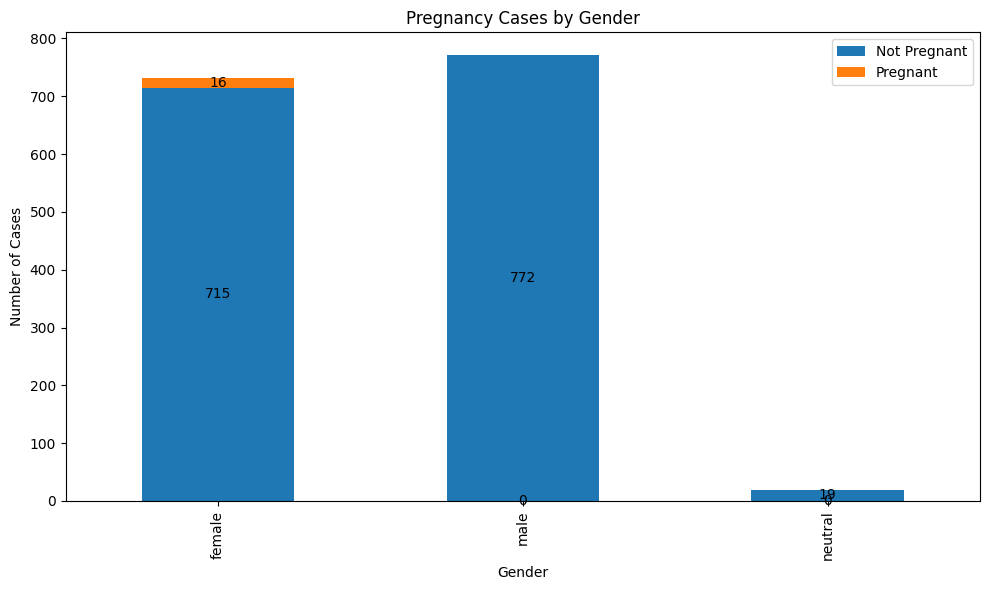

pregnancy    0   1
gender            
female     715  16
male       772   0
neutral     19   0


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already created df['gender'] and df['is_pregnancy']

# Create a cross-tabulation of gender and pregnancy
cross_tab = pd.crosstab(df['gender'], df['pregnancy'])

# Create the stacked bar plot
ax = cross_tab.plot(kind='bar', stacked=True, figsize=(10,6))

# Customize the plot
plt.title('Pregnancy Cases by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Cases')
plt.legend(['Not Pregnant', 'Pregnant'])

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the cross-tabulation for numerical values
print(cross_tab)


In [19]:
# ===== Gender statistics

COLUMN_EVAL='pregnancy'

# Field

if 'field' in df.columns:
    cross_tab = pd.crosstab(df['field'], df[COLUMN_EVAL], margins=True)
    print(f"\nCross-tabulation of field and {COLUMN_EVAL} with total:")
    print(cross_tab)
print("--")

# Clinical Question

if 'clinical_question' in df.columns:
    cross_tab = pd.crosstab(df['clinical_question'], df[COLUMN_EVAL], margins=True)
    print(f"\nCross-tabulation of clinical questions and {COLUMN_EVAL} with total:")
    print(cross_tab)
print("--")

# Figure

if 'figure' in df.columns:
    cross_tab = pd.crosstab(df['figure'], df[COLUMN_EVAL], margins=True)
    print(f"\nCross-tabulation of cfigures and {COLUMN_EVAL} with total:")
    print(cross_tab)
print("--")



Cross-tabulation of field and pregnancy with total:
pregnancy                                           0   1   All
field                                                          
Clinical Challenge                                253   0   253
JAMA Cardiology Clinical Challenge                 73   2    75
JAMA Cardiology Diagnostic Test Interpretation      1   0     1
JAMA Clinical Challenge                           165   3   168
JAMA Dermatology Clinicopathological Challenge    253   2   255
JAMA Diagnostic Test Interpretation                72   0    72
JAMA Neurology Clinical Challenge                  47   1    48
JAMA Oncology Clinical Challenge                   79   2    81
JAMA Oncology Diagnostic Test Interpretation        4   0     4
JAMA Ophthalmology Clinical Challenge             377   1   378
JAMA Pediatrics Clinical Challenge                 55   1    56
JAMA Psychiatry Clinical Challenge                  5   0     5
JAMA Surgery Clinical Challenge                   1

#### b. women health

In [20]:
import re

def identify_woman_health_condition(text):
    # Dictionary of conditions and their related terms
    conditions = {
        'Gynecological': [
            'endometriosis', 'polycystic ovary syndrome', 'pcos', 
            'uterine fibroid', 'cervical cancer', 'ovarian cancer'
        ],
        'Pregnancy-related': [
            'preeclampsia', 'gestational diabetes', 
            'hyperemesis gravidarum', 'placenta previa'
        ],
        'Breast-specific': [
            'breast cancer', 'mastitis'
        ]
    }
    
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Check for negations
    negations = r'\b(no|not|denies|negative for)\b'
    
    # Check for presence of condition-related terms
    for category, terms in conditions.items():
        for term in terms:
            match = re.search(r'\b' + re.escape(term) + r'\b', text_lower)
            if match:
                # Check if there's a negation within 5 words before the term
                pre_context = text_lower[:match.start()].split()[-5:]
                if not any(re.search(negations, word) for word in pre_context):
                    return 1
    
    # If no condition-related terms are found, or if they are negated
    return 0

# Apply the function to create the new column
df['woman_health'] = df['case'].apply(identify_woman_health_condition)

# Display the counts
print(df['woman_health'].value_counts())

# Create a cross-tabulation of gender and woman_health
cross_tab = pd.crosstab(df['gender'], df['woman_health'])
print("\nCross-tabulation of gender and woman's health condition status:")
print(cross_tab)


woman_health
0    1488
1      34
Name: count, dtype: int64

Cross-tabulation of gender and woman's health condition status:
woman_health    0   1
gender               
female        700  31
male          769   3
neutral        19   0


In [21]:
# Filter the DataFrame for cases where gender is male and is_pregnancy is 1
male_x_womenhealth = df[(df['gender'] == 'male') & (df['woman_health'] == 1)]

# Display the number of such cases
print(f"Number of cases classified as pregnant males: {len(male_x_womenhealth)}")

# Display the cases
for index, row in male_x_womenhealth.iterrows():
    print(f"\nCase {index}:")
    print(row['case'][:500] + "...")  # Print first 500 characters of each case
    print(row['link'])  # Print next 500 characters of each case
    print("-" * 80)  # Print a separator line


Number of cases classified as pregnant males: 3

Case 134:
A 59-year-old man with history of cutaneous melanoma of the trunk was referred for evaluation of a pigmented angle lesion in the right eye. He denied any changes in vision, flashes, floaters, eye pain, or eye redness. He denied a history of trauma, intraocular surgery, or inflammation in the eyes. He had a history of stage 3B melanoma treated with ipilimumab complicated by grade 3 colitis refractory to high-dose corticosteroids and infliximab requiring colectomy and stomal hernia after hernia re...
https://jamanetwork.com/journals/jamaophthalmology/fullarticle/2793768
--------------------------------------------------------------------------------

Case 400:
A male patient in his 70s presented an asymptomatic, slightly eroded, translucent nodule on his right nipple (Figure, A). There was a family history of cutaneous melanoma in his 2 sisters, daughter, and nephew and breast cancer in his mother and sister. We completed genetic

In [22]:
df[(df['pregnancy'] == 1) & (df['woman_health'] == 0)]


,link,question,opa,opb,opc,opd,diagnosis,answer_idx,answer,explanation,...,case,clinical_question,normalized_question,test_image,test_lab,test_other,figure,gender,pregnancy,woman_health
211,https://jamanetwork.com/journals/jama/fullarti...,A 39-year-old healthy woman without family his...,Perform repeat breast MRI 4 to 6 weeks after v...,Perform right axillary ultrasound 4 to 6 weeks...,Perform an axillary sentinel lymph node biopsy...,"Perform right axillary ultrasound now, with in...",Vaccination-associated reactive lymphadenopathy,D,"Perform right axillary ultrasound now, with in...",The keys to the correct diagnosis in this case...,...,A 39-year-old healthy woman without family his...,what would you do next?,what would you do next?,1,1,1,1,female,1,0
272,https://jamanetwork.com/journals/jamadermatolo...,A girl younger than 2 years presented with a 1...,Lichen striatus,Idiopathic follicular mucinosis,Follicular mucinous nevus,Trichodysplasia spinulosa,B. Idiopathic follicular mucinosis,B,Idiopathic follicular mucinosis,Histopathological examination revealed accumul...,...,A girl younger than 2 years presented with a 1...,what is your diagnosis?,what is your diagnosis?,0,1,0,1,female,1,0
287,https://jamanetwork.com/journals/jamaneurology...,A 42-year-old woman presented with clinical fe...,Turner syndrome,Fragile X syndrome,Rett syndrome,Cerebral palsy,C. Rett syndrome,C,Rett syndrome,Diagnosing neurodevelopmental disorders at mid...,...,A 42-year-old woman presented with clinical fe...,what is your diagnosis?,what is your diagnosis?,1,1,1,1,female,1,0
298,https://jamanetwork.com/journals/jamacardiolog...,A 40-year-old woman presented with a history o...,Perform balloon mitral valvuloplasty,Perform transcatheter MV-in-ring procedure,Trial medical management with metoprolol and e...,Perform surgical MV replacement,Severe mitral stenosis (MS) after complex MV r...,C,Trial medical management with metoprolol and e...,Severe MS in pregnancy is associated with incr...,...,A 40-year-old woman presented with a history o...,what would you do next?,what would you do next?,1,1,0,1,female,1,0
533,https://jamanetwork.com/journals/jamaoncology/...,"A 31-year-old gravida 1, para 1 woman with a h...",Bleomycin toxic effects,Paraneoplastic skin disease,Polymorphic eruption of pregnancy,Vinblastine toxic effects,A. Bleomycin toxic effects,A,Bleomycin toxic effects,This patient developed bleomycin flagellate de...,...,"A 31-year-old gravida 1, para 1 woman with a h...",what is your diagnosis?,what is your diagnosis?,0,1,1,1,female,1,0
597,https://jamanetwork.com/journals/jamasurgery/f...,"A healthy 29-year-old pregnant woman, with 34 ...",Crohn ileitis,Foreign body ingestion,Ileo-colic intussusception,Adenocarcinoma of small intestine,C. Ileo-colic intussusception,C,Ileo-colic intussusception,Computed tomography revealed edema of small in...,...,"A healthy 29-year-old pregnant woman, with 34 ...",what is your diagnosis?,what is your diagnosis?,1,1,0,1,female,1,0
634,https://jamanetwork.com/journals/jama/fullarti...,"A 36-year-old healthy gravida 3, para 3 woman ...",Administer thrombolytic therapy,"Continue medical therapy alone, with a β-block...",Perform percutaneous coronary intervention (PCI),Refer for coronary artery bypass graft (CABG) ...,Spontaneous coronary artery dissection (SCAD),B,"Continue medical therapy alone, with a β-block...",The keys to the correct diagnosis are the epid...,...,"A 36-year-old healthy gravida 3, para 3 woman ...",what to do next,what would you do next?,1,1,1,1,female,1,0
777,https://jamanetwork.com/journals/jamasurgery/f...,A woman in her mid-20s who was 8 weeks pregnan...,Acute appendicitis,"Salpingitis or sactosalpinx (eg, pyosalpinx or...",Heterotopic pregnancy,Nonspecific abdominal pain or pelvic inflammat...,C. Heterotopic pregnancy with normal intrauter...,C,Heterotopic pregnancy,An MRI confirmed a normal intrauterine pregnan...,...,A woman in her mid-20s who was 8 weeks pregnan...,what is your diagnosi

### 4. age

In [23]:


def extract_age(question_text):
    patterns = [
        (re.compile(r'\b(\d+)[- ]?year[- ]?old\b'), lambda x: int(x.group(1))),
        (re.compile(r'\b(\d+)-year\b'), lambda x: int(x.group(1))),
        (re.compile(r'\bin (their|his|her) (\d+)s\b'), lambda x: int(x.group(2)) + 5),
        (re.compile(r'\b(early|late) (\d+)s\b'), lambda x: int(x.group(2)) + {'early': 2, 'late': 8}[x.group(1)]),
        (re.compile(r'\bin (his|her|their) mid-(\d+)s\b'), lambda x: int(x.group(2)) + 5),
        (re.compile(r'(\d+)[- ]?(days|day)[- ]?old\b'), lambda x: round(int(x.group(1)) / 365, 2)),
        (re.compile(r'(\d+)[- ]?(weeks|week)[- ]?old\b'), lambda x: round(int(x.group(1)) / 52, 2)),
        (re.compile(r'(\d+)[- ]?(months|month)[- ]?old\b'), lambda x: round(int(x.group(1)) / 12, 2)),
        (re.compile(r'\bschool[- ]?aged\b'), lambda x: 10),
        (re.compile(r'\badolescent\b'), lambda x: 15),
        (re.compile(r'\btoddler\b'), lambda x: 2),
        (re.compile(r'\bpreschooler\b'), lambda x: 4),
        (re.compile(r'\bteenager\b'), lambda x: 15),
        (re.compile(r'\byoung adult\b'), lambda x: 22),
        (re.compile(r'\bmiddle[- ]?aged\b'), lambda x: 45),
        (re.compile(r'\belderly\b'), lambda x: 75),
        (re.compile(r'(\d+)[- ]?day[- ]?old\b'), lambda x: round(int(x.group(1)) / 365, 2)),
        (re.compile(r'(\d+)[- ]?week[- ]?old\b'), lambda x: round(int(x.group(1)) / 52, 2)),
        (re.compile(r'newborn'), lambda x: 0.02),
        (re.compile(r'\baged (\d+) years\b'), lambda x: int(x.group(1))),
        (re.compile(r'\byoung (boy|girl|man|woman)\b'), lambda x: 12),
        (re.compile(r'\bnearing the end of (his|her) second decade\b'), lambda x: 19),
        (re.compile(r'\bteenaged? (boy|girl|male|man|woman)\b'), lambda x: 15),  # Added pattern for "teenage/teenaged boy/girl/male/man/woman"
        (re.compile(r'\bgirl in her (early|mid|late)?teens\b'), lambda x: {'early': 13, 'mid': 15, 'late': 17, None: 15}[x.group(1)]),  # Added pattern for "girl in her (early/mid/late) teens"
        (re.compile(r'\bboy in his teens\b'), lambda x: 15),  # Added pattern for "boy in his teens"
        (re.compile(r'\bgirl younger than 2 years\b'), lambda x: 1),  # Added pattern for "girl younger than 2 years"
        (re.compile(r'\bolder adult\b'), lambda x: 65),  # Added pattern for "older adult"
        (re.compile(r'\bpreschool[- ]?age[d]? (boy|girl)\b'), lambda x: 4),  # Added pattern for "preschool-age/aged boy/girl"
        (re.compile(r'\b(white|african american|chinese) teenage (boy|girl)\b'), lambda x: 15),  # Added pattern for "white/African American/Chinese teenage boy/girl"
        (re.compile(r'\bchild younger than 10 years\b'), lambda x: 5),  # Added pattern for "child younger than 10 years"
        (re.compile(r'\bneonate in (her|his) (first|second|third|fourth) week of life\b'), lambda x: round({"first": 1, "second": 2, "third": 3, "fourth": 4}[x.group(2)] / 52, 2)),  # Added pattern for "neonate in his/her first/second/third/fourth week of life"
        (re.compile(r'\b(pre)?adolescent (boy|girl)\b'), lambda x: 10),  # Added pattern for "(pre)adolescent boy/girl"
        (re.compile(r'\bfull[- ]term \d+[- ]g\b'), lambda x: 0),  # Added pattern for "full-term X-g"
        (re.compile(r'\bex utero intrapartum treatment \(EXIT\)\b'), lambda x: 0),  # Added pattern for "ex utero intrapartum treatment (EXIT)"
        (re.compile(r'\bAfrican American (man|woman) in (his|her) (early|mid|late)[- ](\d+)s\b'), lambda x: int(x.group(4)) + {"early": 0, "mid": 5, "late": 8}[x.group(3)]),  # Added pattern for "African American man/woman in his/her early/mid/late-XXs"
        (re.compile(r'\bmale neonate born prematurely at (\d+) weeks\' gestation\b'), lambda x: round(int(x.group(1)) / 52, 2)),  # Added pattern for "male neonate born prematurely at X weeks' gestation"
        (re.compile(r'\ba patient with a history of\b'), lambda x: 50),  # Added pattern for "a patient with a history of"
        (re.compile(r'\bmale in his late teens\b'), lambda x: 18),  # Added pattern for "male in his late teens"
        (re.compile(r'\ban infant (boy|girl), born to\b'), lambda x: 0),  # Added pattern for "an infant boy/girl, born to"
        (re.compile(r'\ban adult with a history of\b'), lambda x: 40),  # Added pattern for "an adult with a history of"
        (re.compile(r'\ba child presented with\b'), lambda x: 8),  # Added pattern for "a child presented with"
        (re.compile(r'\ba (healthy|young|adult|female) (man|woman|patient) with a\b'), lambda x: 30),  # Added pattern for "a healthy/young/adult/female man/woman/patient with a"
        (re.compile(r'\ba (female|male|infant) (infant|neonate)\b'), lambda x: 0),  # Added pattern for "a female/male/infant infant/neonate"
        (re.compile(r'\ba (young|african american|healthy) (man|woman|girl)\b'), lambda x: 20),  # Added pattern for "a young/African American/healthy man/woman/girl"
        (re.compile(r'\ban otherwise healthy adult man\b'), lambda x: 35),  # Added pattern for "an otherwise healthy adult man"
        (re.compile(r'\ba young, previously healthy girl\b'), lambda x: 8),  # Added pattern for "a young, previously healthy girl"
        (re.compile(r'\ba teen[- ]aged boy\b'), lambda x: 15),  # Added pattern for "a teen-aged boy"
        (re.compile(r'\btwo brothers in their late teens\b'), lambda x: 18),  # Added pattern for "two brothers in their late teens"
        (re.compile(r'\ba previously healthy man\b'), lambda x: 30),  # Added pattern for "a previously healthy man"
        (re.compile(r'\ba (male|female) infant with\b'), lambda x: 0),  # Added pattern for "a male/female infant with"
        (re.compile(r'\ba teenage chinese girl\b'), lambda x: 15),  # Added pattern for "a teenage Chinese girl"
        (re.compile(r'\ba woman in her (late )?teens with\b'), lambda x: 18 if x.group(1) else 15),  # Added pattern for "a woman in her (late) teens with"
        (re.compile(r'\ba (young )?black woman with\b'), lambda x: 25),  # Added pattern for "a (young) black woman with"
        (re.compile(r'\ban (infant|male|female) (infant|neonate|girl)\b'), lambda x: 0),  # Added pattern for "an infant/male/female infant/neonate/girl"
        (re.compile(r'\ban ex utero intrapartum treatment \(EXIT\) procedure\b'), lambda x: 0),  # Added pattern for "an ex utero intrapartum treatment (EXIT) procedure"
        (re.compile(r'\ba man presented to\b'), lambda x: 40),  # Added pattern for "a man presented to"
        (re.compile(r'\b(a|an) (patient|woman|man|child|girl|boy|infant|neonate)\b'), lambda x: {
            "patient": 50, "woman": 30, "man": 30, "child": 8, "girl": 12, "boy": 12, "infant": 0, "neonate": 0
        }[x.group(2)]),
        (re.compile(r'\b(with a|presented with|presented to|was born|born to)\b'), lambda x: None),
        (re.compile(r'\b(history of|medical history of|born prematurely at|initially seen in)\b'), lambda x: None),
        (re.compile(r'\b(healthy|adult|female|male|young|teenage|african american|black|chinese)\b'), lambda x: {
            "healthy": 30, "adult": 40, "female": 30, "male": 30, "young": 20, "teenage": 15, "african american": 30, "black": 30, "chinese": 30
        }.get(x.group(1), None)),
        (re.compile(r'\b(ex utero intrapartum treatment \(EXIT\) procedure)\b'), lambda x: 0),
        (re.compile(r'\b(otherwise healthy)\b'), lambda x: None),
        (re.compile(r'\b(previously healthy)\b'), lambda x: None),
        (re.compile(r'\b(a|an) (patient|woman|man|child|girl|boy|infant|neonate)\b'), lambda x: {
            "patient": 50, "woman": 30, "man": 30, "child": 8, "girl": 12, "boy": 12, "infant": 0, "neonate": 0
        }[x.group(2)]),
        (re.compile(r'\b(with a|presented with|presented to|was born|born to)\b'), lambda x: None),
        (re.compile(r'\b(history of|medical history of|born prematurely at|initially seen in)\b'), lambda x: None),
        (re.compile(r'\b(healthy|adult|female|male|young|teenage|african american|black|chinese)\b'), lambda x: {
            "healthy": 30, "adult": 40, "female": 30, "male": 30, "young": 20, "teenage": 15, "african american": 30, "black": 30, "chinese": 30
        }.get(x.group(1), None)),
        (re.compile(r'\b(ex utero intrapartum treatment \(EXIT\) procedure)\b'), lambda x: 0),
        (re.compile(r'\b(otherwise healthy)\b'), lambda x: None),
        (re.compile(r'\b(previously healthy)\b'), lambda x: None),
        (re.compile(r'\ba preschool (boy|girl)\b'), lambda x: 4),  # Added pattern for "a preschool boy/girl"
        (re.compile(r'\ba child presented with\b'), lambda x: 8),  # Added pattern for "a child presented with"
        (re.compile(r'\ba (girl|boy) presented with\b'), lambda x: 12),  # Added pattern for "a girl/boy presented with"
        (re.compile(r'\ba woman in her (early|mid|late)? teens\b'), lambda x: {
            None: 15, "early": 13, "mid": 15, "late": 18
        }[x.group(1)]),  # Added pattern for "a woman in her (early/mid/late) teens"
        (re.compile(r'\ba (teenage|teen-aged) (boy|girl)\b'), lambda x: 15),  # Added pattern for "a teenage/teen-aged boy/girl"
        (re.compile(r'\btwo brothers in their late teens\b'), lambda x: 18),  # Added pattern for "two brothers in their late teens"
        (re.compile(r'\ba man presented to the emergency department\b'), lambda x: 40),  # Added pattern for "a man presented to the emergency department"
    ]

    age = None
    for pattern, age_func in patterns:
        match = pattern.search(question_text)
        if match:
            if callable(age_func):
                age = age_func(match)
            if age is not None:
                return age

    return age

# Apply the extract_age function to the 'question' column to create a new 'age' column
df['age'] = df['question'].apply(extract_age)

# Identify and print rows where age is NaN
print("\nRows where age could not be exactly extracted but mapped according to rules:")
nan_rows = df[df['age'].isna()]
print(len(nan_rows))



Rows where age could not be exactly extracted but mapped according to rules:
12


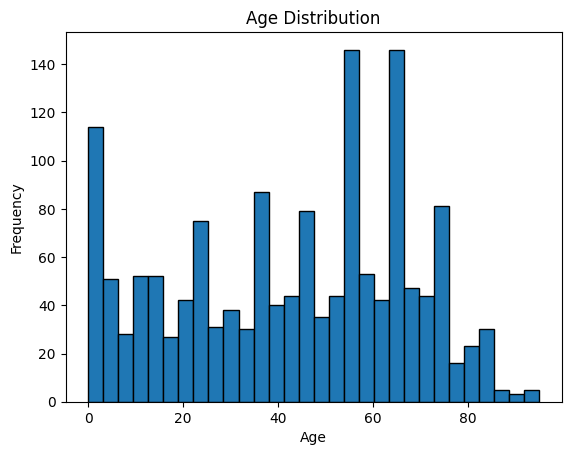

In [24]:
df['age'].value_counts()
import matplotlib.pyplot as plt

plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [25]:
num_cols=['age','test_image','test_lab','test_other','figure','pregnancy','woman_health']


In [26]:
df.columns


Index(['link', 'question', 'opa', 'opb', 'opc', 'opd', 'diagnosis',
       'answer_idx', 'answer', 'explanation', 'field', 'case',
       'clinical_question', 'normalized_question', 'test_image', 'test_lab',
       'test_other', 'figure', 'gender', 'pregnancy', 'woman_health', 'age'],
      dtype='object')

In [27]:
# df.describe(include=[np.number])


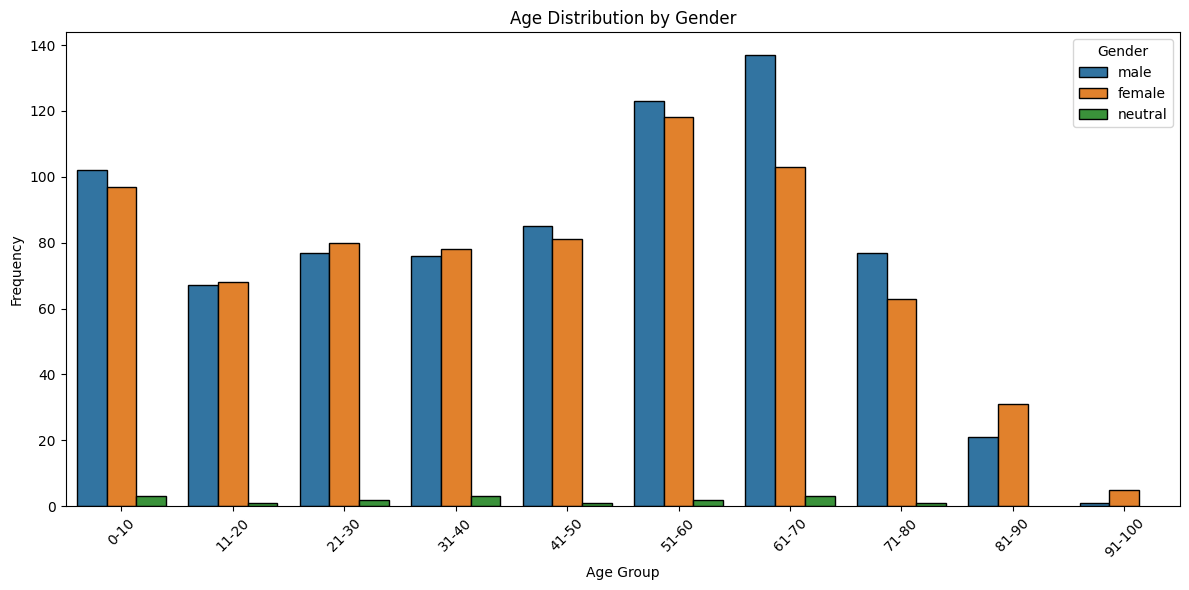

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                         labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='age_group', hue='gender', edgecolor='black')

plt.title('Age Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Gender')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


### ethnicity

#### extracting info

- is race given? in which cases? is it given only if relevant?

In [29]:
# !TODO Takes 37min!
# cases_without_ethnicity = df[df['ethnicity'].isna()]
# print(f"Number of cases without specified ethnicity: {len(cases_without_ethnicity)}")
# for i in range(len(cases_without_ethnicity)):
#     print(f"Case {i+1} of {len(cases_without_ethnicity)}")
#     print(f"The case is: {cases_without_ethnicity['case'].iloc[i]}")
#     print("----")
#     time.sleep(2)  # Pauses for 1 second between prints. Adjust the sleep time as needed.


In [30]:
# cases_without_ethnicity = df[df['ethnicity'].isna()]
# case_572 = cases_without_ethnicity.iloc[571]  # 571 because indexing starts at 0
# print(f"Link for Case 572: {case_572['link']}")


In [31]:
# # India and TB
# cases_without_ethnicity = df[df['ethnicity'].isna()]
# case = cases_without_ethnicity.iloc[1037] 
# print(f"Link for this Case: {case['link']}")


Here the ethnicity is completely relevant
Also, hard to properly answer the question "how do you interpret the results?" when results are not given

In [32]:
# # Nigerian men -> legitimate to give all these details in this case? Dataset is biased itself?
# cases_without_ethnicity = df[df['ethnicity'].isna()]
# case = cases_without_ethnicity.iloc[1070] 
# print(f"Link for this Case: {case['link']}")


#### analysis

cross_tab

In [33]:
import pandas as pd
import spacy
import re
import numpy as np

nlp = spacy.load("en_core_web_sm")

def extract_ethnicity(text):
    # List of ethnicities to look for
    ethnicities = [
        "White", "Black", "Asian", "Hispanic", "Latino", "African American", 
        "Native American", "Pacific Islander", "Chinese", "Nigerian", "Mexican", 
        "Vietnamese", "Indian", "African", "Japanese", "Cambodian", "Caucasian", 
        "Ukrainian", "Costa Rican", "Bahamian", "Laotian", "West African","South Asian"
    ]
    
    # Convert all ethnicities to lowercase
    ethnicities_lower = [e.lower() for e in ethnicities]
    
    # Use spaCy to process the text
    doc = nlp(text)
    
    # Look for ethnicity mentions
    for ent in doc.ents:
        if ent.label_ == "NORP" and ent.text.lower() in ethnicities_lower:
            return ent.text
    
    # If no ethnicity found with spaCy, use regex to look for specific patterns
    for ethnicity in ethnicities:
        pattern = r'\b' + re.escape(ethnicity) + r'\b'
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return ethnicity  # Return the standard capitalization from our list
    
    # Look for more complex patterns
    patterns = [
        r'of ([\w\s]+) descent',
        r'of ([\w\s]+) ancestry',
        r'of ([\w\s]+) heritage'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match and match.group(1).lower() in ethnicities_lower:
            return ethnicities[ethnicities_lower.index(match.group(1).lower())]
    
    return np.nan

# Assuming your DataFrame is called 'df' and the column with the case text is called 'case'
df['ethnicity'] = df['case'].apply(extract_ethnicity)


In [34]:
cross_tab=pd.crosstab(df['ethnicity'], df['field'])
cross_tab.style.background_gradient(cmap="Reds")


field,Clinical Challenge,JAMA Cardiology Clinical Challenge,JAMA Cardiology Diagnostic Test Interpretation,JAMA Clinical Challenge,JAMA Dermatology Clinicopathological Challenge,JAMA Diagnostic Test Interpretation,JAMA Neurology Clinical Challenge,JAMA Oncology Clinical Challenge,JAMA Oncology Diagnostic Test Interpretation,JAMA Ophthalmology Clinical Challenge,JAMA Pediatrics Clinical Challenge,JAMA Surgery Clinical Challenge
ethnicity,,,,,,,,,,,,
African,1,0,0,0,0,0,0,0,0,0,0,0
African American,5,1,1,5,4,0,0,0,0,13,2,2
Asian,2,0,0,1,0,1,2,0,0,4,1,0
Bahamian,0,0,0,0,1,0,0,0,0,0,0,0
Black,8,0,0,6,8,0,1,2,0,10,4,0
Cambodian,0,0,0,0,0,0,0,0,0,1,0,0
Caucasian,0,0,0,0,0,0,0,0,0,1,0,0
Chinese,1,0,0,0,2,0,1,0,0,1,0,1
Hispanic,3,0,0,0,0,0,0,1,0,6,1,0


In [35]:
print(df['ethnicity'].value_counts().sort_values(ascending=False))


ethnicity
White               364
Black                39
African American     33
Asian                11
Hispanic             11
Chinese               6
Japanese              4
Nigerian              2
South Asian           2
Mexican               2
Indian                2
Vietnamese            1
African               1
West African          1
Cambodian             1
Caucasian             1
Bahamian              1
Name: count, dtype: int64


In [36]:
cross_tab=pd.crosstab(df['ethnicity'], df['field']).sort_values(by='ethnicity', ascending=False)
cross_tab.style.background_gradient(cmap="Reds")


field,Clinical Challenge,JAMA Cardiology Clinical Challenge,JAMA Cardiology Diagnostic Test Interpretation,JAMA Clinical Challenge,JAMA Dermatology Clinicopathological Challenge,JAMA Diagnostic Test Interpretation,JAMA Neurology Clinical Challenge,JAMA Oncology Clinical Challenge,JAMA Oncology Diagnostic Test Interpretation,JAMA Ophthalmology Clinical Challenge,JAMA Pediatrics Clinical Challenge,JAMA Surgery Clinical Challenge
ethnicity,,,,,,,,,,,,
White,38,8,0,61,43,7,18,30,1,105,18,35
West African,0,0,0,0,0,0,0,0,0,0,0,1
Vietnamese,0,0,0,0,0,1,0,0,0,0,0,0
South Asian,0,1,0,0,0,0,0,0,0,1,0,0
Nigerian,0,0,0,2,0,0,0,0,0,0,0,0
Mexican,0,0,0,1,0,0,0,0,0,1,0,0
Japanese,0,0,0,1,3,0,0,0,0,0,0,0
Indian,0,0,0,0,1,0,0,1,0,0,0,0
Hispanic,3,0,0,0,0,0,0,1,0,6,1,0


## 6, cases

In [37]:
# Add case Id
df['case_id'] = (df['case'].shift() != df['case']).cumsum()

# Add version
df = df.assign(version='original')


# verify it's okay
df.head()


,link,question,opa,opb,opc,opd,diagnosis,answer_idx,answer,explanation,...,test_other,figure,gender,pregnancy,woman_health,age,age_group,ethnicity,case_id,version
0,https://jamanetwork.com/journals/jamadermatolo...,A man in his 30s with AIDS presented with acut...,Herpes simplex virus,Histoplasmosis,Molluscum contagiosum,Mpox,D. Mpox,D,Mpox,The photographs demonstrate a Tzanck smear usi...,...,0,1,male,0,0,35.0,31-40,NaN,1,original
1,https://jamanetwork.com/journals/jama/fullarti...,An 80-year-old man with stage II bladder carci...,Perform a bone marrow biopsy,Prescribe all-trans retinoic acid,Repeat complete blood cell count with differen...,Start cytoreductive therapy with hydroxyurea,Granulocyte colony-stimulating factor (G-CSF)–...,C,Repeat complete blood cell count with differen...,The key to the correct diagnosis is recognizin...,...,1,1,male,0,0,80.0,71-80,White,2,original
2,https://jamanetwork.com/journals/jamaneurology...,A 68-year-old man presented with progressive r...,Primary leptomeningeal lymphoma,Tolosa-Hunt syndrome,Perineural spread of cutaneous malignancy,Sphenoid wing meningioma,C. Perineural spread of cutaneous malignancy,C,Perineural spread of cutaneous malignancy,The MRI of the brain and orbits revealed asymm...,...,1,1,male,0,0,68.0,61-70,NaN,3,original
3,https://jamanetwork.com/journals/jamaoncology/...,A 31-year-old man presented with left cervical...,Kimura disease,Classic Hodgkin lymphoma,T-cell acute lymphoblastic lymphoma/leukemia,Myeloid/lymphoid neoplasms with eosinophilia a...,D. Myeloid/lymphoid neoplasms with eosinophili...,D,Myeloid/lymphoid neoplasms with eosinophilia a...,The differential diagnoses in young men with e...,...,1,1,male,0,0,31.0,31-40,White,4,original
4,https://jamanetwork.com/journals/jamaotolaryng...,A 28-year-old woman presented with a 5-day his...,Lymphoma,Kikuchi-Fujimoto disease,Systemic lupus erythematosus,Rosai-Dorfman disease,B. Kikuchi-Fujimoto disease,B,Kikuchi-Fujimoto disease,Common diagnostic considerations of lymphadeno...,...,1,1,female,0,0,28.0,21-30,NaN,5,original


In [38]:
df.columns


Index(['link', 'question', 'opa', 'opb', 'opc', 'opd', 'diagnosis',
       'answer_idx', 'answer', 'explanation', 'field', 'case',
       'clinical_question', 'normalized_question', 'test_image', 'test_lab',
       'test_other', 'figure', 'gender', 'pregnancy', 'woman_health', 'age',
       'age_group', 'ethnicity', 'case_id', 'version'],
      dtype='object')

In [39]:
for i in range(6):
    print(f"CASE: {df['case_id'].iloc[i]} - VERSION: {df['version'].iloc[i]} - GENDER: {df['gender'].iloc[i]}")
    case_text = df['case'].iloc[i]
    print(case_text[:300] + "..." if len(case_text) > 500 else case_text)
    print("---")


CASE: 1 - VERSION: original - GENDER: male
A man in his 30s with AIDS presented with acute-onset painful scattered umbilicated papulopustules and ovoid ulcerated plaques with elevated, pink borders on the face, trunk, and extremities (Figure, A). The patient also had a new-onset cough but was afebrile and denied other systemic symptoms. Due ...
---
CASE: 2 - VERSION: original - GENDER: male
An 80-year-old man with stage II bladder carcinoma (T2NXM0) and atrial fibrillation treated with apixaban presented to the emergency department with 1 week of fatigue and 2 days of dyspnea on exertion. One week prior to presentation, he received a fourth cycle of carboplatin/gemcitabine for bladder ...
---
CASE: 3 - VERSION: original - GENDER: male
A 68-year-old man presented with progressive right-sided facial numbness and weakness, vision changes, and headaches. His symptoms began 5 years earlier with right temple numbness, which expanded to include the entire right face and mouth. He then develop

# Final df saving

In [40]:
df.columns


Index(['link', 'question', 'opa', 'opb', 'opc', 'opd', 'diagnosis',
       'answer_idx', 'answer', 'explanation', 'field', 'case',
       'clinical_question', 'normalized_question', 'test_image', 'test_lab',
       'test_other', 'figure', 'gender', 'pregnancy', 'woman_health', 'age',
       'age_group', 'ethnicity', 'case_id', 'version'],
      dtype='object')

In [41]:
df.to_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_pp.csv", index=False)


In [42]:
df=pd.read_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_pp.csv")


In [43]:
df['version'].value_counts()


version
original    1522
Name: count, dtype: int64

# Data Augmentation

In [44]:
import pandas as pd

def filter_dataframe(df, apply_ethnicity_filter=True, apply_gender_filter=True):
    """
    Filter the dataframe based on ethnicity and gender criteria.
    
    Parameters:
    df (pd.DataFrame): The input dataframe to be filtered.
    apply_ethnicity_filter (bool): Whether to apply the ethnicity filter.
    apply_gender_filter (bool): Whether to apply the gender filter.
    
    Returns:
    pd.DataFrame: The filtered dataframe.
    """
    
    exclude_mask = pd.Series(False, index=df.index)
    
    if apply_gender_filter:
        gender_mask = (
            (df['pregnancy'] == 1) |  # Exclude pregnancy cases
            (df['woman_health'] == 1)  # Exclude woman_health cases
        )
        exclude_mask |= gender_mask
    
    if apply_ethnicity_filter:
        ethnicity_mask = (
            (df['field'] == 'JAMA Dermatology Clinicopathological Challenge') |
            (df['ethnicity'].notna()) )
        exclude_mask |= ethnicity_mask
    
    return df[~exclude_mask]


## 1. Gender

In [45]:
import re
import pandas as pd

def augment_gender(df):
    augmented_rows = []
    
    gender_mappings = {
        'male': {'female': [
            (r'\b(male )?(man|patient)\b', 'woman'), (r'\bboy\b', 'girl'), (r'\bmale\b', 'female'),
            (r'\bhe\b', 'she'), (r'\bhim\b', 'her'), (r'\bhis\b', 'her'),
            (r'\bhimself\b', 'herself'), (r'\bson\b', 'daughter')
        ]},
        'female': {'male': [
            (r'\b(female )?(woman|patient)\b', 'man'), (r'\bgirl\b', 'boy'), (r'\bfemale\b', 'male'),
            (r'\bshe\b', 'he'), (r'\bher\b', 'him'), (r'\bher\b', 'his'),
            (r'\bherself\b', 'himself'), (r'\bdaughter\b', 'son')
        ]},
        'neutral': {
            'male': [
                (r'\bperson\b', 'man'), (r'\bchild\b', 'boy'), 
                (r'\bpatient\b', 'male patient'),
                (r'\bthey\b', 'he'), (r'\bthem\b', 'him'), (r'\btheir\b', 'his'),
                (r'\bthemselves\b', 'himself'), (r'\boffspring\b', 'son')
            ],
            'female': [
                (r'\bperson\b', 'woman'), (r'\bchild\b', 'girl'), 
                (r'\bpatient\b', 'female patient'),
                (r'\bthey\b', 'she'), (r'\bthem\b', 'her'), (r'\btheir\b', 'her'),
                (r'\bthemselves\b', 'herself'), (r'\boffspring\b', 'daughter')
            ]
        }
    }
    
    neutral_replacements = [
        (r'\b(male |female )?(man|woman|patient)\b', 'patient'),
        (r'\b(boy|girl)\b', 'child'),
        (r'\b(male|female)\b', 'person'),
        (r'\b(he|she)\b', 'they'),
        (r'\b(him|her)\b', 'them'),
        (r'\b(his|her)\b', 'their'),
        (r'\b(himself|herself)\b', 'themselves'),
        (r'\b(son|daughter)\b', 'offspring')
    ]

    def create_gender_version(row, target_gender):
        new_row = row.copy()
        original_gender = row['gender']
        
        if original_gender != target_gender:
            new_row['version'] = f'augmented_{target_gender}_from{original_gender}'
            new_row['gender'] = target_gender
            
            if target_gender in gender_mappings.get(original_gender, {}):
                for old, new in gender_mappings[original_gender][target_gender]:
                    new_row['case'] = re.sub(old, lambda m: new if m.group(0).islower() else new.capitalize(), new_row['case'], flags=re.IGNORECASE)
            elif target_gender == 'neutral':
                for old, new in neutral_replacements:
                    new_row['case'] = re.sub(old, lambda m: new if m.group(0).islower() else new.capitalize(), new_row['case'], flags=re.IGNORECASE)
        
        return new_row

    for _, row in df.iterrows():
        augmented_rows.append(row)  # Keep the original
        if row['gender'] != 'female':
            augmented_rows.append(create_gender_version(row, 'female'))
        if row['gender'] != 'male':
            augmented_rows.append(create_gender_version(row, 'male'))
        if row['gender'] != 'neutral':
            augmented_rows.append(create_gender_version(row, 'neutral'))

    return pd.DataFrame(augmented_rows)


In [46]:
# ====== DATA AUGMENTATION

# ----- 0. Loading the data
df=pd.read_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_pp.csv")
df_gender=df.copy()

# ----- 1. Function definition
# see above

# ----- 2. Data augmentation
df_gender = augment_gender(df_gender)
print(df_gender['gender'].value_counts())

# ------ 3. Statistics
print(f"Number of cases : {len(df_gender)}")
print("\nGender distribution in filtered DataFrame:")
print(df_gender['gender'].value_counts(normalize=True))
print("\nRemaining woman_health cases:")
print(df_gender[df_gender['woman_health'] == 1]['gender'].value_counts())
print("\nRemaining pregnancy cases:")
print(df_gender['pregnancy'].value_counts())

# ------ 4. Saving the df
df_gender.to_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_gender.csv", index=False)


gender
male       1522
female     1522
neutral    1522
Name: count, dtype: int64
Number of cases : 4566

Gender distribution in filtered DataFrame:
gender
male       0.333333
female     0.333333
neutral    0.333333
Name: proportion, dtype: float64

Remaining woman_health cases:
gender
female     34
male       34
neutral    34
Name: count, dtype: int64

Remaining pregnancy cases:
pregnancy
0    4518
1      48
Name: count, dtype: int64


In [47]:
# ====== DATA FILTRATION

# ------- 0. Loading the data
df_gender=pd.read_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_gender.csv")

# ------- 1. Defining the mask
exclude_mask_gender = (
    (df_gender['pregnancy'] == 1) | # Exclude pregnancy cases
    (df_gender['woman_health'] == 1) # Exclude woman_health cases
)

# ------- 2. Applying the mask
df_gender_filtered = df_gender[~exclude_mask_gender]

# ------- 3. Statistics
print(f"Number of cases after filtering: {len(df_gender_filtered)}")
print("\nGender distribution in filtered DataFrame:")
print(df_gender_filtered['gender'].value_counts(normalize=True))

print("\nRemaining woman_health cases:")
print(df_gender_filtered[df_gender_filtered['woman_health'] == 1]['gender'].value_counts())

print("\nRemaining pregnancy cases:")
print(df_gender_filtered['pregnancy'].value_counts())

# ----- 4. Saving the df
df_gender_filtered.to_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_gender_filtered.csv", index=False)


Number of cases after filtering: 4419

Gender distribution in filtered DataFrame:
gender
male       0.333333
female     0.333333
neutral    0.333333
Name: proportion, dtype: float64

Remaining woman_health cases:
Series([], Name: count, dtype: int64)

Remaining pregnancy cases:
pregnancy
0    4419
Name: count, dtype: int64


In [48]:
import numpy as np

def print_augmented_cases(df, num_cases=3):
    # Get unique case_ids
    unique_cases = df['case_id'].unique()
    
    # Separate neutral and non-neutral cases
    neutral_cases = df[
        (df['gender'] == 'neutral') & 
        (df['version'] == 'original')
    ]['case_id'].unique()
    non_neutral_cases = np.setdiff1d(unique_cases, neutral_cases)
    
    # Determine how many of each type to select
    num_neutral = 5
    num_non_neutral = min(len(non_neutral_cases), num_cases - num_neutral)
    
    # Randomly select cases
    selected_neutral = np.random.choice(neutral_cases, num_neutral, replace=False) if num_neutral > 0 else []
    selected_non_neutral = np.random.choice(non_neutral_cases, num_non_neutral, replace=False) if num_non_neutral > 0 else []
    selected_cases = np.concatenate([selected_neutral, selected_non_neutral])
    
    for case_id in selected_cases:
        case_rows = df[df['case_id'] == case_id]
        
        print(f"Original and Augmented versions for Case ID: {case_id}")
        print("=" * 80)
        
        # Sort rows to ensure original version comes first
        sorted_rows = case_rows.sort_values(by='version', key=lambda x: np.where(x == 'original', 0, 1))
        
        for _, row in sorted_rows.iterrows():
            print(f"VERSION: {row['version']} - GENDER: {row['gender']}")
            case_text = row['case']
            print(case_text[:300] + "..." if len(case_text) > 300 else case_text)
            print("-" * 80)
        
        print("\n")

# Usage
NUM_CASES = 10
print_augmented_cases(df_gender_filtered, num_cases=NUM_CASES)


Original and Augmented versions for Case ID: 250
VERSION: original - GENDER: neutral
A patient in their early 20s with no medical history or previous symptoms presented for severe frontal headaches and progressive blurred vision in the left eye more than the right eye for several weeks.No localizing signs were documented on neurologic examination. Magnetic resonance imaging (MRI) of...
--------------------------------------------------------------------------------
VERSION: augmented_female_fromneutral - GENDER: female
A female patient in her early 20s with no medical history or previous symptoms presented for severe frontal headaches and progressive blurred vision in the left eye more than the right eye for several weeks.No localizing signs were documented on neurologic examination. Magnetic resonance imaging (MR...
--------------------------------------------------------------------------------
VERSION: augmented_male_fromneutral - GENDER: male
A male patient in his early 20s with no

## 2. Gender x Ethnicity

In [49]:
with open('/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/ethnicityxgender.txt', 'r') as file:
    ethnicityxgender_list = [line.strip() for line in file]
print(ethnicityxgender_list)


['White', 'Black', 'Asian']


In [50]:
# The gender_mappings, neutral_replacements, and gender_words should be defined as before
gender_mappings = {
    'male': {'female': [
        (r'\b(male )?(man|patient)\b', 'woman'), (r'\bboy\b', 'girl'), (r'\bmale\b', 'female'),
        (r'\bhe\b', 'she'), (r'\bhim\b', 'her'), (r'\bhis\b', 'her'),
        (r'\bhimself\b', 'herself'), (r'\bson\b', 'daughter')
    ]},
    'female': {'male': [
        (r'\b(female )?(woman|patient)\b', 'man'), (r'\bgirl\b', 'boy'), (r'\bfemale\b', 'male'),
        (r'\bshe\b', 'he'), (r'\bher\b', 'him'), (r'\bher\b', 'his'),
        (r'\bherself\b', 'himself'), (r'\bdaughter\b', 'son')
    ]},
    'neutral': {
        'male': [
            (r'\bperson\b', 'man'), (r'\bchild\b', 'boy'), 
            (r'\bpatient\b', 'male patient'),
            (r'\bthey\b', 'he'), (r'\bthem\b', 'him'), (r'\btheir\b', 'his'),
            (r'\bthemselves\b', 'himself'), (r'\boffspring\b', 'son')
        ],
        'female': [
            (r'\bperson\b', 'woman'), (r'\bchild\b', 'girl'), 
            (r'\bpatient\b', 'female patient'),
            (r'\bthey\b', 'she'), (r'\bthem\b', 'her'), (r'\btheir\b', 'her'),
            (r'\bthemselves\b', 'herself'), (r'\boffspring\b', 'daughter')
        ]
    }
}

neutral_replacements = [
    (r'\b(male |female )?(man|woman|patient)\b', 'patient'),
    (r'\b(boy|girl)\b', 'child'),
    (r'\b(male|female)\b', 'person'),
    (r'\b(he|she)\b', 'they'),
    (r'\b(him|her)\b', 'them'),
    (r'\b(his|her)\b', 'their'),
    (r'\b(himself|herself)\b', 'themselves'),
    (r'\b(son|daughter)\b', 'offspring')
]

gender_words = ['man', 'woman', 'boy', 'girl', 'male', 'female', 'patient', 'child', 'person']


In [51]:
import re
import pandas as pd
import itertools

def augment_gender_ethnicity(df, ethnicityxgender_list):
    augmented_rows = []

    def create_gender_ethnicity_version(row, target_gender, ethnicity):
        new_row = row.copy()
        original_gender = row['gender']
        
        new_row['ethnicity'] = ethnicity
        new_row['version'] = f'augmented_{ethnicity}_{target_gender}_from{original_gender}'
        new_row['gender'] = target_gender
        
        def replace_with_ethnicity_and_gender(match):
            word = match.group(0)
            new_word = word
            
            # Change gender if needed
            if original_gender != target_gender:
                for old, new in gender_mappings.get(original_gender, {}).get(target_gender, []) + neutral_replacements:
                    if re.match(old, word, re.IGNORECASE):
                        new_word = new
                        break
            
            # Add ethnicity only for certain words
            if new_word.lower() in ['man', 'woman', 'boy', 'girl', 'male', 'female', 'patient', 'child', 'person']:
                if new_word.islower():
                    return f"{ethnicity} {new_word}"
                else:
                    return f"{ethnicity} {new_word.capitalize()}"
            else:
                return new_word.lower() if word.islower() else new_word.capitalize()
        
        # Combine all gender words and pronouns into a single pattern
        all_words = set(gender_words + 
                        [word for mappings in gender_mappings.values() for mapping in mappings.values() for _, word in mapping] +
                        [word for _, word in neutral_replacements])
        pattern = r'\b(' + '|'.join(all_words) + r')\b'
        
        # Apply the replacement in a single pass
        new_row['case'] = re.sub(pattern, replace_with_ethnicity_and_gender, new_row['case'], flags=re.IGNORECASE)
        
        return new_row

# The gender_mappings, neutral_replacements, and gender_words should be defined as before

    for _, row in df.iterrows():
        augmented_rows.append(row)
        
        for ethnicity in ethnicityxgender_list:
            if ethnicity != row['ethnicity']:  # Only create new versions for different ethnicities
                augmented_rows.append(create_gender_ethnicity_version(row, row['gender'], ethnicity))
                other_genders = [g for g in ['male', 'female', 'neutral'] if g != row['gender']]
                for other_gender in other_genders[:2]:  # Take only two other genders
                    augmented_rows.append(create_gender_ethnicity_version(row, other_gender, ethnicity))

    return pd.DataFrame(augmented_rows)



In [52]:
# ====== DATA AUGMENTATION

# ----- 0. Loading the data
df=pd.read_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_pp.csv")
df_genderxethnicity=df.copy()

# ----- 1. Function definition
df_genderxethnicity = filter_dataframe(df_genderxethnicity, apply_ethnicity_filter=True, apply_gender_filter=True)

# ----- 2. Data augmentation
df_genderxethnicity = augment_gender_ethnicity(df_genderxethnicity,ethnicityxgender_list)
print(df_genderxethnicity['gender'].value_counts())

# ------ 3. Statistics
print(f"Number of cases : {len(df_genderxethnicity)}")
print("\nGender distribution in filtered DataFrame:")
print(df_genderxethnicity['gender'].value_counts(normalize=True))
print("\nRemaining woman_health cases:")
print(df_genderxethnicity[df_genderxethnicity['woman_health'] == 1]['gender'].value_counts())
print("\nRemaining pregnancy cases:")
print(df_genderxethnicity['pregnancy'].value_counts())

# ------ 4. Saving the df
df_genderxethnicity.to_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_genderxethniciy.csv", index=False)


gender
male       3537
female     3474
neutral    3019
Name: count, dtype: int64
Number of cases : 10030

Gender distribution in filtered DataFrame:
gender
male       0.352642
female     0.346361
neutral    0.300997
Name: proportion, dtype: float64

Remaining woman_health cases:
Series([], Name: count, dtype: int64)

Remaining pregnancy cases:
pregnancy
0    10030
Name: count, dtype: int64


In [53]:
import numpy as np
import pandas as pd

def print_augmented_gender_ethnicity_cases(df, num_cases=5):
    print("\nUnique values in 'version' column:", df['version'].unique())
    
    # Get unique case_ids
    unique_cases = df['case_id'].unique()
    print(f"\nTotal unique cases: {len(unique_cases)}")
    
    # Separate original cases
    original_cases = df[df['version'] == 'original']['case_id'].unique()
    print(f"Original cases: {len(original_cases)}")
    
    if len(original_cases) == 0:
        print("No original cases found. Selecting from all unique cases.")
        original_cases = unique_cases
    
    # Randomly select cases
    selected_cases = np.random.choice(original_cases, min(len(original_cases), num_cases), replace=False)
    print(f"Selected {len(selected_cases)} cases for display")
    
    for case_id in selected_cases:
        case_rows = df[df['case_id'] == case_id]
        
        print(f"\nOriginal and Augmented versions for Case ID: {case_id}")
        print("=" * 100)
        
        # Sort rows to ensure original version comes first
        sorted_rows = case_rows.sort_values(by='version', key=lambda x: np.where(x == 'original', 0, 1))
        
        for _, row in sorted_rows.iterrows():
            print(f"VERSION: {row['version']} - GENDER: {row['gender']} - ETHNICITY: {row['ethnicity']}")
            case_text = row['case']
            print(case_text[:300] + "..." if len(case_text) > 300 else case_text)
            print("-" * 100)
        
    print("\nEnd of selected cases.")

# Usage example:
print_augmented_gender_ethnicity_cases(df_genderxethnicity, num_cases=3)



Unique values in 'version' column: ['original' 'augmented_White_male_frommale'
 'augmented_White_female_frommale' 'augmented_White_neutral_frommale'
 'augmented_Black_male_frommale' 'augmented_Black_female_frommale'
 'augmented_Black_neutral_frommale' 'augmented_Asian_male_frommale'
 'augmented_Asian_female_frommale' 'augmented_Asian_neutral_frommale'
 'augmented_White_female_fromfemale' 'augmented_White_male_fromfemale'
 'augmented_White_neutral_fromfemale' 'augmented_Black_female_fromfemale'
 'augmented_Black_male_fromfemale' 'augmented_Black_neutral_fromfemale'
 'augmented_Asian_female_fromfemale' 'augmented_Asian_male_fromfemale'
 'augmented_Asian_neutral_fromfemale'
 'augmented_White_neutral_fromneutral' 'augmented_White_male_fromneutral'
 'augmented_White_female_fromneutral'
 'augmented_Black_neutral_fromneutral' 'augmented_Black_male_fromneutral'
 'augmented_Black_female_fromneutral'
 'augmented_Asian_neutral_fromneutral' 'augmented_Asian_male_fromneutral'
 'augmented_Asian_fem

## Ethnicity - later

In [54]:
# ======= DATA AUGMENTATION

# ----- 0. Loading the data
# -------- Ethnicity list
with open('ethnicity_list.txt', 'r') as file:
    ethnicity_list = [line.strip() for line in file]
print(ethnicity_list)

# -------- Dataframe
df=pd.read_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_pp.csv")
df_ethnicity=df.copy()


# ----- 1. Function definition
def augment_with_ethnicity(df):
    nlp = spacy.load('en_core_web_sm')

    # Add ethnicity
    def add_ethnicity(text, ethnicity):
        doc = nlp(text)
        modified_tokens = []
        ethnicity_added = False
        for token in doc:
            if not ethnicity_added and token.text.lower() in ['man','male','boy', 'woman', 'female','girl','patient','child','individual','person','infant','adult','farmer','professional']:
                modified_tokens.append(f"{ethnicity} {token.text}")
                ethnicity_added = True
            else:
                modified_tokens.append(token.text)
        
        if not ethnicity_added:
            print(f"Ethnicity not added for case: {text[:100]}...")  # Print first 100 characters
            return None  # Return None if ethnicity wasn't added
        return ' '.join(modified_tokens)
    # Initialisation
    augmented_cases = []
    # Create augmented
    for _, row in df.iterrows():
        # Keep the original case
        original_case = row.copy()
        original_case['version'] = 'original'
        augmented_cases.append(original_case)

        # Create augmented cases for all ethnicities
        for ethnicity in ethnicity_list:
            augmented_case = row.copy()
            augmented_text = add_ethnicity(augmented_case['case'], ethnicity)
            if augmented_text is not None:
                augmented_case['case'] = augmented_text
                augmented_case['ethnicity'] = ethnicity
                augmented_case['version'] = 'augmented'
                augmented_cases.append(augmented_case)

    return pd.DataFrame(augmented_cases)

# Apply the augmentation
df_ethnicity = augment_with_ethnicity(df_ethnicity)

# Print some statistics
print(f"Number of cases after augmentation: {len(df_ethnicity)}")
print("\nDistribution of original vs augmented cases:")
print(df_ethnicity['version'].value_counts(normalize=True))
print("\nEthnicity distribution in augmented DataFrame:")
print(df_ethnicity['ethnicity'].value_counts(normalize=True))

# Save the augmented dataset
df_ethnicity.to_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_ethnicity.csv", index=False)


['Asian', 'Chinese', 'Indian', 'Black', 'African', 'Caribbean', 'Latin', 'Hispanic', 'White', 'English', 'Arab', 'Middle-Eastern', 'Gypsy', 'Roma', 'Indigenous', 'Mixed', 'Other']
Ethnicity not added for case: A 6-month-old daughter of nonconsanguineous parents was seen with multiple polycyclic dark to less d...
Ethnicity not added for case: A 6-month-old daughter of nonconsanguineous parents was seen with multiple polycyclic dark to less d...
Ethnicity not added for case: A 6-month-old daughter of nonconsanguineous parents was seen with multiple polycyclic dark to less d...
Ethnicity not added for case: A 6-month-old daughter of nonconsanguineous parents was seen with multiple polycyclic dark to less d...
Ethnicity not added for case: A 6-month-old daughter of nonconsanguineous parents was seen with multiple polycyclic dark to less d...
Ethnicity not added for case: A 6-month-old daughter of nonconsanguineous parents was seen with multiple polycyclic dark to less d...
Ethnicity not ad

In [55]:
# ===== DATA FILTRATION

# ------ 1. Defining the mask 
exclude_mask_ethnicity = (
    (df_ethnicity['field'] == 'JAMA Dermatology Clinicopathological Challenge') |  # Exclude pregnancy cases
    ((df_ethnicity['version'] == 'original'))  # Exclude woman_health cases for females
)

# -------- 2. Applying the mask
df_ethnicity_filtered = df_ethnicity[~exclude_mask_ethnicity]

# ------- 3. Statistics
print(f"Number of cases after filtering: {len(df_ethnicity_filtered)}")
print("\nGender distribution in filtered DataFrame:")
print(df_ethnicity_filtered['gender'].value_counts(normalize=True))

print("\nRemaining woman_health cases:")
print(df_ethnicity_filtered[df_ethnicity_filtered['woman_health'] == 1]['gender'].value_counts())

print("\nRemaining pregnancy cases:")
print(df_ethnicity_filtered['pregnancy'].value_counts())

# ----- 4. Saving the df
df_ethnicity_filtered.to_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/thesis_clinical_llm_bias/data/jama_ethnicity_filtered.csv", index=False)


Number of cases after filtering: 25823

Gender distribution in filtered DataFrame:
gender
male       0.507571
female     0.479921
neutral    0.012508
Name: proportion, dtype: float64

Remaining woman_health cases:
gender
female    527
male       51
Name: count, dtype: int64

Remaining pregnancy cases:
pregnancy
0    25551
1      272
Name: count, dtype: int64
